# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

**Authors**
- Joaquim Marset Alsina
- Jesús Molina Rodríguez de Vera

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

*   Change the path of the directories according to your drive location.

In [2]:
import os

lab_path = r'/content/drive/MyDrive/CV - Lab/Lab10/'

root_path = f'{lab_path}TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

classes_file = os.path.join(root_path, 'classes.csv')

*   Define the constants needed for training the model

In [3]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [4]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

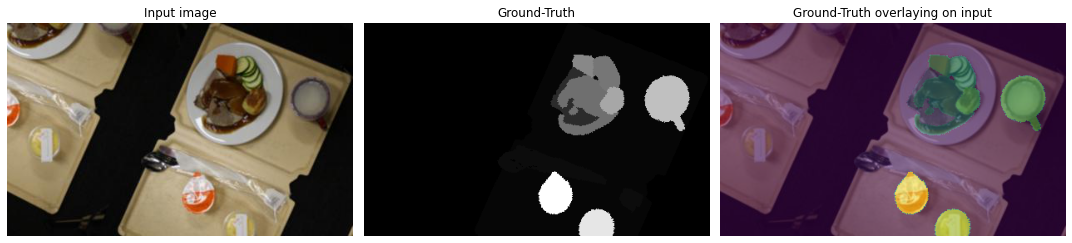

In [5]:
# solution

from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import load_img

i = 14

train_image = imread(train_img_paths[i])
ground_truth_mask = load_img(train_mask_paths[i], color_mode='grayscale')
ground_truth_autocontrast = autocontrast(ground_truth_mask)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for ax in axs.flatten():
    ax.axis("off")

axs[0].imshow(train_image)
axs[0].set_title("Input image")

axs[1].imshow(ground_truth_autocontrast, cmap='gray')
axs[1].set_title("Ground-Truth")

axs[2].imshow(train_image)
axs[2].imshow(ground_truth_autocontrast, alpha=0.5)
axs[2].set_title('Ground-Truth overlaying on input')

fig.tight_layout()

In [6]:
import pandas as pd
import numpy as np

classes_name = pd.read_csv(classes_file)["_name"].values

classes = np.unique(ground_truth_mask)
print('Classes:')
for class_idx in classes:
    print(classes_name[class_idx])

Classes:
background
tray
cutlery
roast lamb
gravy
zucchini
pumpkin
jacket potato
soup
custard
orange juice


# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [7]:
# solution

from tensorflow import keras
import numpy as np

class ImageGeneator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [9]:
# Free up RAM in case the model definition cells were run multiple times

from tensorflow import keras
keras.backend.clear_session()

In [10]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [11]:
# solution

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [12]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGeneator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGeneator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [13]:
# solution

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",  metrics=["accuracy"])

*   Instantiate a ModelCheckpoint callback to save only the best model

In [14]:
# solution

callbacks = [
    keras.callbacks.ModelCheckpoint("tray_food_segmentation.h5", save_best_only=True)
]

*   Train the model using fit method

In [15]:
# solution

# Uncomment to train the model again
# model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, verbose=1)

weights_path = f'{lab_path}tray_food_segmentation.h5'
model.load_weights(weights_path)

# Visualize predictions

*   Generate predictions for all images in the validation set

In [16]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGeneator(batch_size, img_size, test_img_paths, test_mask_paths)

In [17]:
# solution

val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [18]:
# solution

val_pred_masks = np.argmax(val_preds, axis=-1)
print(f'Predicted masks shape: {val_pred_masks.shape}')

Predicted masks shape: (8, 160, 160)


*   Read the test mask images to create the ground truth

In [19]:
# solution
from skimage.util import img_as_int

val_gts = np.array([masks_batch.squeeze(0) for _, masks_batch in val_gen]).squeeze(-1)
print(f'Ground-truth masks shape: {val_gts.shape}')

Ground-truth masks shape: (8, 160, 160)


*   For each validation image, find the jaccard similarity score

In [20]:
# solution
from sklearn.metrics import jaccard_score

val_jaccard = [jaccard_score(gt.flatten(), pred.flatten(), average='micro') 
                for gt, pred in zip(val_gts, val_pred_masks)]
np.mean(val_jaccard)

0.8834062005923442

*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

The Jaccard similarity score can be used generally to assess the performance of a classification model (remember that semantic segmentation is just a pixel-wise classification problem).

The `average` parameter determines the type of averaging performed on the data to get the final Jaccard value.

According to the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html), there are 6 possible values for this parameter:

- **None**: the Jaccard score for each class is returned. This can be useful in several scenarios in which understanding the performance of the model for the different classes is important to analyse the results.

- **'binary'**: Only reports the results for one of the classes (specified by the `pos_label` parameter). Thus, it is only applicable if targets are binary. It is useful in pure binary classification problems (positive/negative), as well as when only the performance relative to a particular label/class is relevant for the evaluation of the model at hand.

- **'micro'**: Computes the metric globally by using the number of total true positives, false negatives and false positives. That is, no distinction between classes is made during the evaluation. Thus, an overall assessment of the classification's ability is obtained, regardless of specific classes. Micro-averaging may be preferred in multi-label settings, including multi-class classification where a majority class is to be ignored.

- **'macro'**: Calculates the metric for each label (class) and finds the unweighted mean. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.

- **'weighted'**: a variant of 'macro' that takes class imbalance into account. It computes the Jaccard score for each label and then computes the weighted average. The weights are obtained from the support: the number of true instances for each label or class. Therefore, it can be handy for problems with high class imbalance.

- **'samples'**: Especially useful for multilabel classification. It does not calculate a per-class Jaccard, instead, calculates the metric over the true and predicted classes for each sample in the evaluation data and returns their average.

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

In [21]:
from PIL.Image import fromarray

def display_image(image, ground_truth_mask, predicted_mask):
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    for ax in axs.flatten():
        ax.axis('off')

    ground_truth_mask = fromarray(ground_truth_mask)
    ground_truth_mask = autocontrast(ground_truth_mask)

    axs[0, 0].imshow(image)
    axs[0, 1].imshow(ground_truth_mask, cmap='gray')
    
    axs[0, 2].imshow(image)
    axs[0, 2].imshow(ground_truth_mask, alpha=0.5)

    axs[1, 0].imshow(predicted_mask, cmap='gray')

    axs[1, 1].imshow(image)
    axs[1, 1].imshow(predicted_mask, alpha=0.5)

    axs[1, 2].imshow(ground_truth_mask)
    axs[1, 2].imshow(predicted_mask, alpha=0.5)

    axs[0, 0].set_title('Image')
    axs[0, 1].set_title('Ground-truth Mask')
    axs[0, 2].set_title('Overlayed Ground-truth')
    axs[1, 0].set_title('Predicted Mask')
    axs[1, 1].set_title('Overlayed Predicted')
    axs[1, 2].set_title('Predicted over Ground-truth')

    plt.tight_layout()
    plt.show()

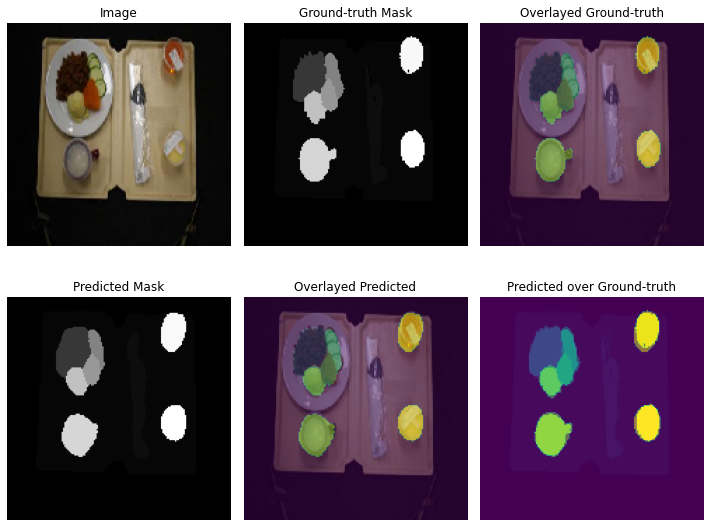

In [22]:
# solution

num_test_images = len(test_img_paths)

random_idx = random.randint(0, num_test_images)

image = load_img(test_img_paths[random_idx], target_size=img_size)

display_image(image, val_gts[random_idx], val_pred_masks[random_idx])

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

As we have previously stated, semantic segmentation is nothing else than a pixel-wise classification problem. Therefore, any metric that can be used to evaluate a classifier can be applied here.

We have already used the Jaccard index, which is also known as the intersection over union (that we have used, for example, in object detection problems). As we can see in the image below, with this metric we are trying to assess the degree of overlap between the pixels that actually belong to a class and the pixels that we have predicted to be of that class.

![](https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png?1641117052316)

Thus, the Jaccard similarity index is a set similarity measure. There are other metrics (widely used in classification problems in general and segmentation in particular) that can be applied to compare two sets. One of these measures is the Sørensen–Dice coefficient (or simply Dice) whose expression is as follows:
$$
D(X,Y) = 2\cdot \frac{|X\cap Y|}{|X|+|Y|}
$$

This coefficient is very used in semantic segmentation evaluation, particularly in the domain of medical image segmentation. More generally, we can include the Tversky index given by
$$
S(X, Y) = \frac{| X \cap Y |}{| X \cap Y | + \alpha | X - Y | + \beta | Y - X |} 
$$

where $\alpha,\beta \geq 0$ parametrize the influence of sets differences. This metric is a generalization of metrics like Jaccard and Dice, and different parameter values can be used depending on the problem, domain and dataset.

There are other alternatives that take "spatial" information into account. For example, the Hausdorff distance measures the distance between two subsets in a metric space in terms of the distances between their boundaries:

$$
d_{\mathrm {H} }(X,Y)=\max \left\{\,\sup _{x\in X}d(x,Y),\,\sup _{y\in Y}d(X,y)\,\right\}
$$

The image below helps to understand this metric:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Hausdorff_distance_sample.svg/640px-Hausdorff_distance_sample.svg.png?1641123019373)

In addition to the mentioned metrics, we could include some simple ones like for example pixel accuracy (i.e. the percentage of corrected classified pixels). It is the easiest to understand and apply, but also is not a very good one.  
Another simple metric could be comparing the number of classified objects of the different classes.

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [23]:
def plot_images(images, predicted_masks):
    num_images = images.shape[0]

    fig, axs = plt.subplots(num_images, 3, figsize=(25, 25))
    for ax in axs.flatten():
        ax.axis('off')

    for i in range(num_images):
        image = images[i].astype('uint8')
        predicted_mask = predicted_masks[i].astype('uint8')

        axs[i, 0].imshow(image)
        axs[i, 1].imshow(predicted_mask, cmap='gray')
        axs[i, 2].imshow(image)
        axs[i, 2].imshow(predicted_mask, alpha=0.4)

        axs[i, 0].set_title('Image')
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 2].set_title('Masked overlayed')

        classes = np.unique(predicted_masks[i])
        print(f'Custom image {i} classes:')
        for class_index in classes:
            print(classes_name[class_index])
        print()

    plt.tight_layout()
    plt.show()

Custom image 0 classes:
background
tray
cutlery
roast lamb
ham
spinach and pumpkin risotto
gravy
zucchini
pumpkin
side salad
tartare sauce
creamed potato
margarine
soup
milk
jelly
lemon sponge
water

Custom image 1 classes:
background
tray
cutlery
ham
bean
boiled rice
spinach and pumpkin risotto
gravy
zucchini
pumpkin
sandwich
side salad
tartare sauce
jacket potato
creamed potato
bread
margarine
soup
milk
vanilla yogurt
jelly
custard
apple juice
orange juice
water

Custom image 2 classes:
background
tray
cutlery
roast lamb
spinach and pumpkin risotto
zucchini
pumpkin
side salad
margarine
soup
canned fruit
vanilla yogurt
jelly
water

Custom image 3 classes:
background
tray
cutlery
roast lamb
bean
beef mexican meatballs
gravy
zucchini
pumpkin
sandwich
side salad
soup
vanilla yogurt
jelly
custard
lemon sponge
orange juice
water

Custom image 4 classes:
background
tray
cutlery
roast lamb
beef tomato casserole
bean
boiled rice
beef mexican meatballs
spinach and pumpkin risotto
gravy
zucchin

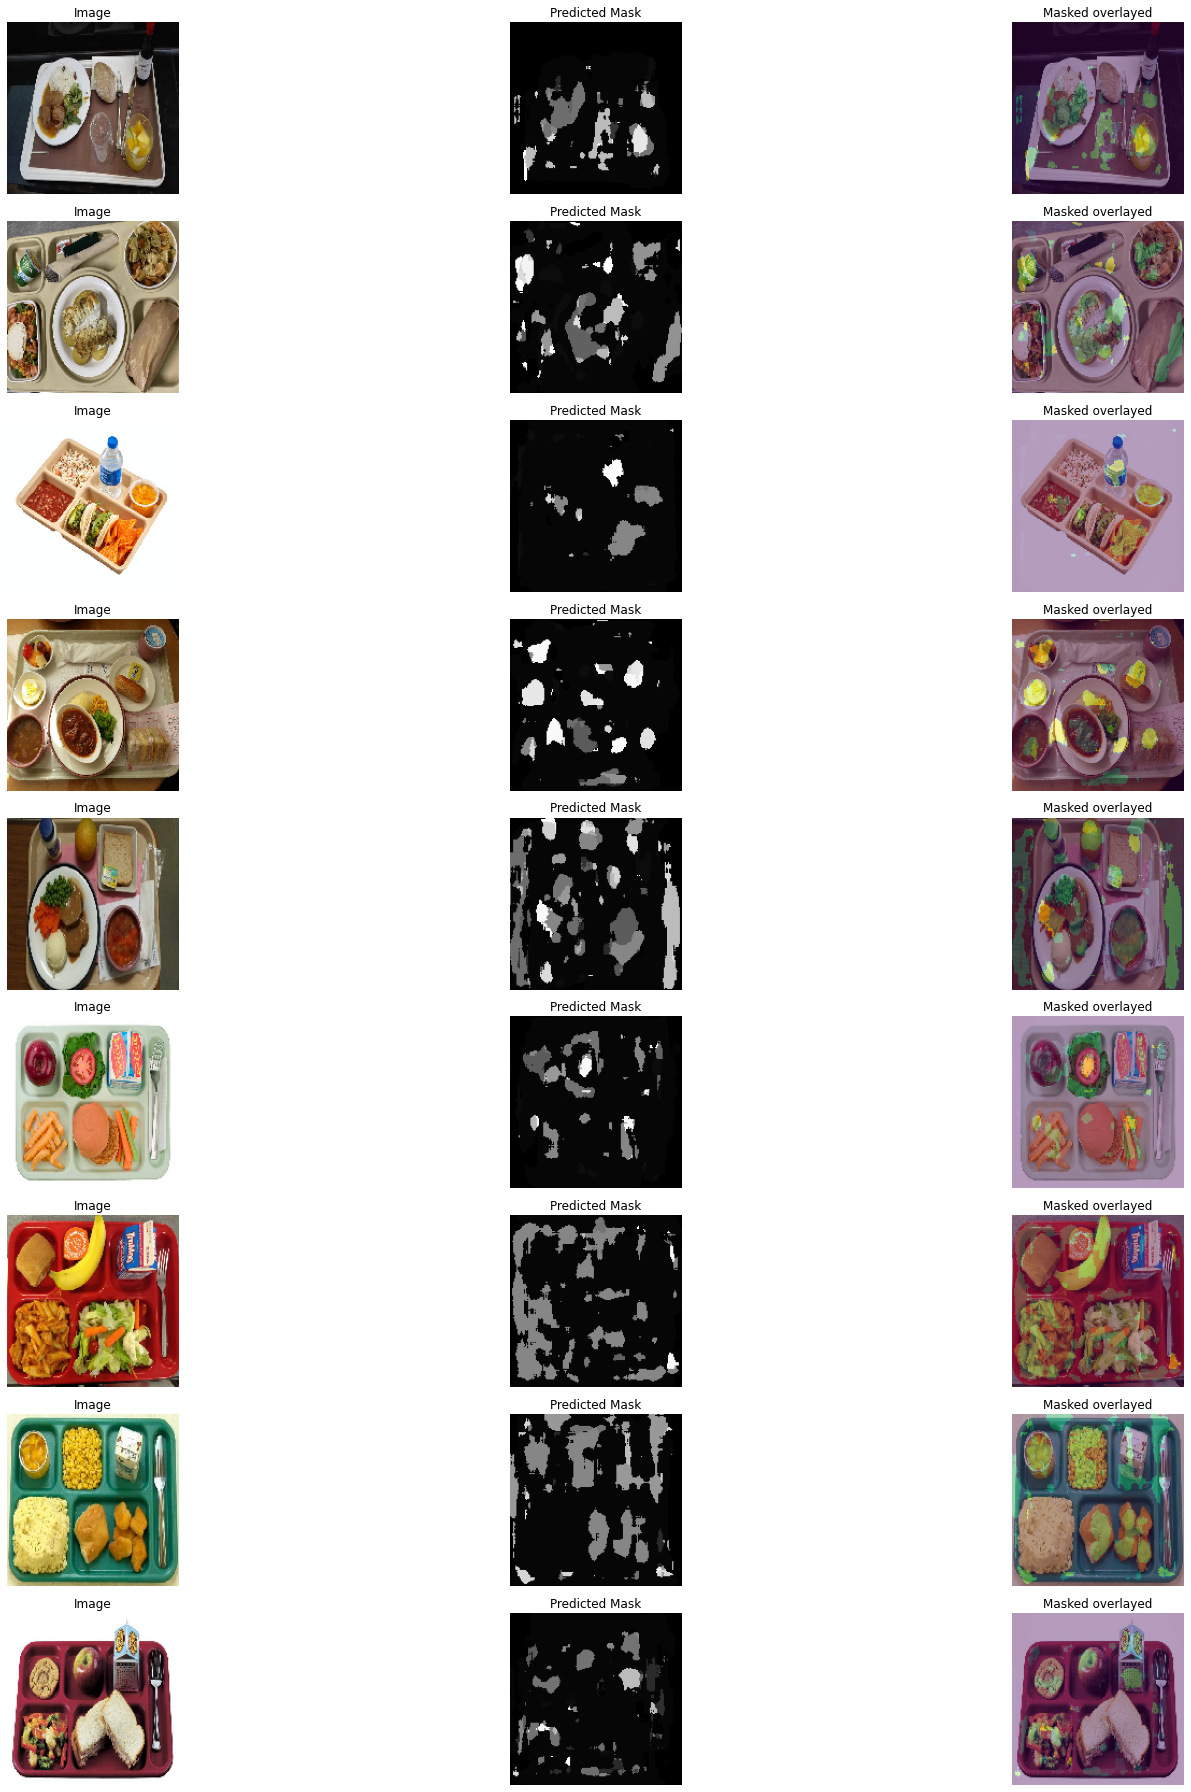

In [24]:
# solution
custom_image_folder = f'{lab_path}downloaded_images/'

custom_image_paths = [os.path.join(custom_image_folder, file_name) for file_name in os.listdir(custom_image_folder)]
num_custom = len(custom_image_paths)

custom_batch = np.zeros((num_custom, *img_size, 3), dtype='float32')

for i, path in enumerate(custom_image_paths):
    custom_batch[i] = load_img(path, target_size=img_size)

predictions_wild = model.predict(custom_batch)
predicted_masks_wild = np.argmax(predictions_wild, axis=-1)

plot_images(custom_batch, predicted_masks_wild)

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

As we can observe, the performance of the model drops significantly with respect to the validation/test images that we have used before. There might be several reasons for this, as we explain in the next lines.


On the one hand, the images of the dataset are all of them very homogeneous: there is a pure black background, and a more or less centred tray in the middle of the image. The tray has always the same shape, and its rotation and the relative position of the camera is also uniform. However, in "in the wild", things are not so perfect: different colours and shapes in the background, different trays and even different perspectives (with trays partially outside the FOV of the camera). Moreover, the illumination is also less uniform than in the dataset.

All these changes lead to the network "detecting" food in the background, being "fooled" by the shadows or ignoring the food. Indeed it fails to find classes for which it has been trained, like boiled rice, bottles of water (this last one may be because of the perspective from which the bottle is observed) or sandwiches (because it is packed in one of the "wild" images, and the model does not recognize it).

Regarding the classes not considered in the dataset like tacos or nachos (the image with the plain white background) we observe 2 kinds of behaviour:
- The tacos are mainly ignored, the model does not consider them to be food so they are predicted to be part of the background (very common in that particular image).
- In the case of nachos, they are classified as one of the kinds of food that the model has previously seen. Particularly, if we take a closer look at that example we discover that they are classified as "pumpkin" (class 22), probably due to the orange colour.
In the answer to the next question, we talk more generally about these problems in the field of computer vision.

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

The problems mentioned in the last answer are actually the main problems that have to be taken into account when designing and training computer vision models (and machine learning models in general) that are meant to be used in real-world scenarios, in which unpredictable situations that were not present at training time may appear. Indeed, the aim of machine learning is to create models that are able to generalize from a limited set of samples, so these challenges are the core of machine learning. 

However, we have seen two main kinds of problems:
- Changes in the conditions (light, perspective, ...), as well as intra-class variation, prevent the model from properly dealing with classes it has been trained for. Thus, the model did not learn a general enough representation of those objects.  This might be caused by a poor dataset or a "weak" model. That is why it is important to have a heterogeneous and big enough training set that allows the model to be robust to those variations. However, sometimes it is not easy or even possible to have such a dataset, and different techniques like data augmentation can be used to artificially augment the dataset and increase the generalization capacity of the model. Anyway, it is important to have representative enough validation and test sets to ensure that the model is indeed able to generalise to unseen samples and conditions.
- The model fails because of the presence of elements that were not considered in the training dataset, that is, classes of objects that were not considered during the creation of the model (like the nachos in the previous example). There are some techniques (like zero-shot learning) to enable the models to deal with these situations. Moreover, it is also useful in some domains to train the model so as to detect elements that do not match any of the previously observed classes, and even create "new" classes by clustering the "uncategorizable" elements.

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

Semantic segmentation is, as previously mentioned, a simple pixel-wise classification: given an image, we are interested in knowing which class of a given set every pixel of the image belongs to. 

In instance segmentation, we also want to know the class for every pixel, but additionally, we are interested in knowing the exact instance of that class that is associated with every pixel.

The image below is an example that clearly highlights the differences between both problems. The image at the left is an example of semantic segmentation, while the image in the right is an instance segmentation of the same image.

![](https://www.researchgate.net/profile/Vinorth-Varatharasan/publication/339328277/figure/fig1/AS:864554888204291@1583137356688/Semantic-segmentation-left-and-Instance-segmentation-right-8.ppm)

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

The U-Net receives its name because of the shape of its diagram, which we display in the following figure:

![](https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png)

This is an encoder-decoder architecture, in which the encoder is the left branch of the "U" and the decoder is the right branch of the "U". The novelty of this network, that made it become state-of-the-art in image segmentation (especially for medical applications in which it is still the most commonly used network) is that it proposed a solution to a problem that is inherent to convolutional networks for image segmentation: the application of sequences of convolutional and pooling layers reduces the resolution of the representations, which helps to aggregate information from more distant pixels (increase the size of the context) in successive convolutional layers while keeping a small kernel size. Nevertheless, this reduction makes that the output of the network presents a lower resolution than the original image, which leads to coarser and less precise final segmentations. The U-Net proposes a solution based on this encoder-decoder duality.

The encoder, also referred to as the downsampling or analysis path works as a "traditional" convolutional neural network. This part is in charge of obtaining progressively more abstract representations of the input by applying a sequence of convolutional and pooling layers. In the diagram above, a $572\times572$ image is transformed into a representation of $1024$ features and a resolution of $28\times28$. This first "half" of the network acts as a feature extractor: it tries to "understand" the image, and obtain features that are useful to segment the image. It reduces the spatial information to gain semantic information.

However, as we have already noted, this $28\times28$ representation is too coarse to obtain a precise segmentation of the original $572\times572$ image. The goal of the decoder, also known as upsampling or synthesis path is building a high-resolution segmentation. In other words, from this coarse representation, it has to reconstruct a high-resolution segmentation. How is that achieved? Thanks to the application of two basic elements:
- Upsampling blocks. These blocks are the symmetrical version of the convolutional blocks. Instead of using pooling operators, they apply layers that increase the resolution of the representation. In the original U-Net paper, those layers were "transposed convolution layers" (good explanation [here](https://distill.pub/2016/deconv-checkerboard/)), although other alternatives like interpolation layers have been used in the literature.  
- Skip connections. The upsampling blocks only have non-precise representations, so some artifacts might be introduced while increasing the resolution. To avoid that, the U-Net directly connects both branches of the "U", forwarding less abstract representations from previous stages of the network that are concatenated with the upsampled representations. Thus, precise information is made available to construct high-resolution segmentations. 

While in the original U-Net the architecture is completely "symmetric", this is not necessarily the case. Indeed, it is not uncommon to use as encoder or "backbone" another convolutional network architecture to take advantage of their ability as feature extractors. For example, in [this paper](https://doi.org/10.1007/s11227-021-03664-0) an EfficientNet is used as an encoder of a U-Net for medical applications. The idea is the same, extracting relevant features from the input and forwarding skip connections from different parts of the "backbone" to the upsampling path.

*   What is upsampling?

**Solution**

Upsampling is, in this domain, the process of obtaining representations with higher resolution from lower-resolution representations. In the previous answer, we have already talked about the role of upsampling in the U-Net, so we think that this question has already been answered.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

This term is widely used when talking about convolutional neural networks in general.

The term "feature channels" in U-Net refers to the different features of a representation at a given point of the architecture. That is, the dimension is determined by the number of convolutional filters applied in every convolutional layer. Let's use the diagram above to make this concept clearer. After the first convolution, we obtain a representation with 64 feature channels; in the part at the bottom of the diagram, there are 1024 feature channels, and so on.

One of the characteristics of the U-Net is that the number of feature channels increases while we go deeper in the "U". Thus, in deeper layers, there are more features or "semantic" information but less "spatial" information (coarser representations) and vice-versa. Moreover, in the upsampling path, there are a great number of feature channels (those coming from the upsampling path itself and the ones coming from the skip connections). This allows the network to propagate context information to higher resolution layers.

*   What are some applications of U-Net?

**Solution**

The main applications of U-Net are linked to semantic segmentation. It was firstly proposed for medical image segmentation ([paper](https://arxiv.org/abs/1505.04597)), and it is still widely used for the segmentation of different medical images ([cardiac images](https://doi.org/10.1016/j.cmpb.2021.106548), [pancreas](https://arxiv.org/abs/1804.03999), [multiple organs](https://www.nature.com/articles/s41592-020-01008-z)...). Many modifications of the original U-Net have been proposed, like the [3d U-Net](https://arxiv.org/abs/1606.06650) that deals directly with 3D volumes obtained from medical scanning devices (like MRI or CT). 

However, it is used in other fields like surface segmentation from satellite images (like [this paper](https://ieeexplore.ieee.org/abstract/document/8900453) or [this one](https://www.scitepress.org/Papers/2020/93373/93373.pdf)), or lane detection for autonomous vehicle (like [this paper](https://www.researchgate.net/publication/331646621_Robust_U-Net-based_Road_Lane_Markings_Detection_for_Autonomous_Driving)).

Additionally, thanks to its encoder-decoder architecture, some authors have used it to create models that learn how to reconstruct high-resolution representations from low-resolution images (which is commonly known as Super-Resolution): [paper](https://openaccess.thecvf.com/content_CVPRW_2019/papers/WiCV/Hu_RUNet_A_Robust_UNet_Architecture_for_Image_Super-Resolution_CVPRW_2019_paper.pdf).


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Monday, the 3rd of January, 2022**